# Spatially Incoherent Array

Another notebook in the series of analysis of Mark's trap array design. 

This notebook explores the effect of Gaussian array generation with "speckle" fields. 

In [1]:
## general imports
import numpy as np
from numpy import *
from numpy.fft import fft,fft2,fftshift,ifftshift

from scipy.special import j0, j1
from matplotlib import colors
import matplotlib.pyplot as plt
from time import time
from random import random as rand

## local imports
import os,sys
sys.path.append(os.path.join("..","."))
from field_funcs import * # my helper functions
from physconsts import *

## make the display wide
from IPython.core.display import HTML, display, Image
display(HTML("<style>.container{width:100% !important;}</style>"))

# image path 
imagedir = os.path.join('..','images')
print("images saved in", imagedir)

images saved in ..\images


## Speckle fields

Speckle fields can be generated experimentally by reflecting spectrally coherent light from a surface with variations on the order of the wavelength. The incident light interferes at the surface and the resulting reflection looks speckled. The light is still narrowband, but with amplitude variations accross the transverse plane of the wave. 

Here I generate such a field by assuming no correlations in amplitudes in the two transverse directions. 

In [2]:
def speckle_mask(pts, tau):
    """
    Naive creation of a speckle field
    
    Args:
        pts: number of pts in each dimension
        tau: the period of the speckle
    Returns:
        speckle: a pts*pts 2D numpy array with float amplitudes in [0,1]
    """
    speckle = np.zeros((pts,pts))

    for i in range(pts//tau):
        for j in range(pts//tau):
            speckle[i*tau:(i+1)*tau, j*tau:(j+1)*tau] = rand()
    
    return speckle

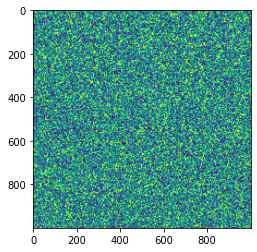

In [4]:
pts = 1000 # pixels
tau = 5 # speckle period [pixels] 
speckle = speckle_mask(pts, tau)

plt.imshow(speckle)

90 909 90 909


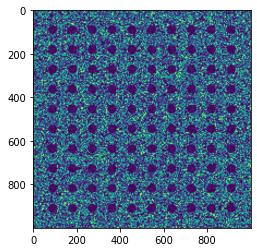

In [51]:
# create the input field by applying a mask to the speckle field

pts = 1000
phi_std=None # [rad]
pos_std=None
r_aper = .75 # aperture reflectivity
t_plate = 0.8 # plate transmissivity
mask, x0pts, w = spot_mask(xnum1, ynum1, a, dx, dy, pts, phi_std=phi_std, pos_std=pos_std, aperture=1-r_aper, plate=t_plate)
mask*=speckle

plt.imshow(real(conjugate(mask)*mask))

## Speckle field Fourier propagation 

In [3]:
## physics and lens params
# lengths in m

lmbda = 8.05e-7
nu0 = c/lmbda
dnu = 1e6 # full-width half maximum of spectrum

# lorentzian scaled to have peak value = 1
L = lambda nu: lorentzian(nu, nu0, dnu)/lorentzian(nu0,nu0,dnu)
k = 2*pi/lmbda

f1 = 0.5 # lens focal length
f2 = 0.005
A0 = 1 # input field amplitude

# input mask params
a = 1e-4 # spot radius
dx = 4.3*a # grid periodicity
dy = dx 
b = f1*3.8317/(a*k) # fourier plane filter radius
xnum1 = ynum1 = 10 # number of grid points in each dimension

## output field Talbot lengths
Lx2 = f2*dx/f1 # output array periodicity
Ly2 = f2*dy/f1
zTalbotx = 2*Lx2**2/lmbda
zTalboty = 2*Ly2**2/lmbda 

## print out parameters
print("length units are m:")
print(f'b={b:0.6f}, a={a}, dx={dx}, dy={dy}, xnum={xnum1}, ynum={ynum1}')
print(f'zTalbotx={zTalbotx:0.6f}, zTalboty={zTalboty:0.6f}')

length units are m:
b=0.002455, a=0.0001, dx=0.00043, dy=0.00043, xnum=10, ynum=10
zTalbotx=0.000046, zTalboty=0.000046


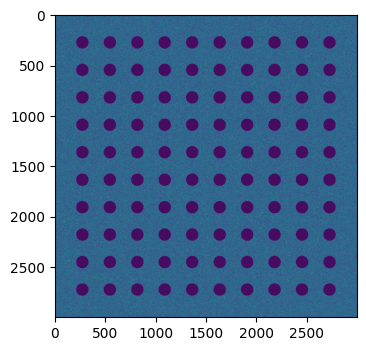

In [12]:
pts = 3000
phi_std=None # [rad]
pos_std=None
r_aper = .75 # aperture reflectivity
t_plate = 0.8 # plate transmissivity
mask, x0pts, w = spot_mask(xnum1, ynum1, a, dx, dy, pts, phi_std=phi_std, pos_std=pos_std, aperture=1-r_aper, plate=t_plate)

rwidth = (xnum1+1)*dx # realspace field width
tau = int(pts*2*lmbda/rwidth) # speckle period

mask*=speckle_mask(pts,tau)

fig = plt.subplots(dpi=100)
plt.imshow(real(conjugate(mask)*mask))

In [18]:
tau = int(pts*2*lmbda/rwidth) # speckle period
tau

1

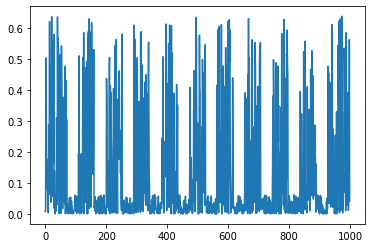

In [71]:
# verify that dark regions are in fact are also speckly
plt.plot(range(pts),real(conjugate(mask)*mask)[810,:])

In [4]:
# input and output fields
pts = 3000
padding= 100 # might not even need this
phi_std=None # [rad]
pos_std=None
r_aper = .75 # aperture reflectivity
t_plate = 0.8 # plate transmissivity
mask, x0pts, w = spot_mask(xnum1, ynum1, a, dx, dy, pts, phi_std=phi_std, pos_std=pos_std, aperture=1-r_aper, plate=t_plate)

wavelengths = 2 # number of wavelengths the speckles span
rwidth = (xnum1+1)*dx # realspace field width
tau = int(pts*wavelengths*lmbda/rwidth) # speckle period
mask*=speckle_mask(pts,tau)
focal_field = np.zeros(mask.shape,complex)
talbot_field = np.zeros(mask.shape,complex)

zvals = [f2,f2+zTalbotx]
 
# input field 
field0 = mask

# FOURIER PLANE FIELD -- propogate the field and apply a filter in the Fourier plane
rr0 = sqrt(x0pts**2 + x0pts.reshape(-1,1)**2)
field1,x1pts = lens_xform(f1,field0,b,f1,k,x0pts,rr0,padding,masked=False,padval=1,
                          logging=False)

# output axial planes to evaluate
for z2 in zvals:

    # OUTPUT FIELD -- propagate field in Fourier plane to z2 behind lens f2 
    rr1 = sqrt(x1pts**2 + x1pts.reshape(-1,1)**2)
    field2,x2pts = lens_xform(z2,field1,b,f2,k,x1pts,rr1,padding,masked=True,
                              logging=False)

    if z2 == f2:
        focal_field += field2
    else:
        talbot_field += field2

In [5]:
tau = int(pts*wavelengths*lmbda/rwidth)
int(tau*rwidth/(pts*lmbda)+0.5)

2

In [6]:
savefig = True

saved file to ..\images\plot_speckle_1lmbda_input_10x10.png
saved file to ..\images\plot_speckle_2lmbda_z2_0um_10x10.png
saved file to ..\images\plot_speckle_2lmbda_z2_45um_10x10.png


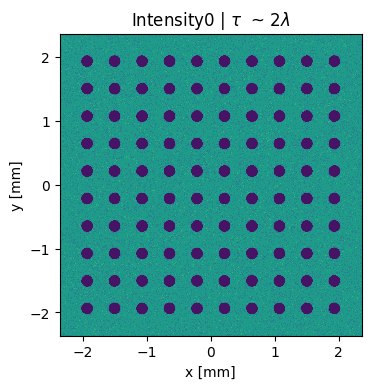

In [7]:
if plt:
    plt.close()

scl = 1e3
fig, ax = figax(xlabel=r'x [mm]', ylabel=r'y [mm]')
fig.dpi=100
title = rf'Intensity0 | $\tau$  ~ {int(tau*rwidth/(pts*lmbda)+0.5)}$\lambda$'
# title += '\n Normalized to focal plane intensity'
ax.set_title(title)
cax = ax.contourf(x0pts*scl, x0pts*scl, real(conjugate(field0)*field0), levels=linspace(0,1,11))

if savefig:
    fname = os.path.join(imagedir, 
                         f'plot_speckle_{int(tau*rwidth/(pts*lmbda)+0.5)}lmbda_input_{xnum1}x{ynum1}.png')
    plt.savefig(fname, bbox_inches='tight')
    print(f"saved file to {fname}")

for outputfield,z2 in zip([focal_field,talbot_field],zvals):
    I2_xy = conjugate(outputfield)*outputfield
    if f2 - z2 == 0:
        I2xy_max = amax(I2_xy)
    I2_xy /= I2xy_max

    scl = 1e6
    fig, ax = figax(xlabel=r'x [$\mu$m]', ylabel=r'y [$\mu$m]')
    fig.dpi=100
    title = rf'Intensity2 | $\tau$ ~ {int(tau*rwidth/(pts*lmbda)+0.5)}$\lambda$ | z2={int((f2 - z2)*1e6)}$\mu$m'
    # title += '\n Normalized to focal plane intensity'
    ax.set_title(title)
    if f2 - z2 == 0:
        cax = ax.contourf(x2pts*scl, x2pts*scl, real(I2_xy), levels=linspace(0,1,11))
    else:
        cax = ax.contourf(x2pts*scl, x2pts*scl, real(I2_xy), levels=linspace(0,1,11))
    # fig.colorbar(cax, ticks=arange(0,1.2,.2))
    fig.colorbar(cax)
    
    if savefig:
        fname = os.path.join(imagedir, 
                             f'plot_speckle_{int(tau*rwidth/(pts*lmbda)+0.5)}lmbda_z2_{int(abs((f2 - z2)*1e6))}um_{xnum1}x{ynum1}.png')
        plt.savefig(fname, bbox_inches='tight')
        print(f"saved file to {fname}")
        plt.close()
savefig = False

In [6]:
savefig=True
fig, ax = plt.subplots()
ax.set_title(rf'Intensity slice comparison | $\tau$ ~ {int(tau*rwidth/(pts*lmbda)+0.5)}$\lambda$')
ax.set_xlabel("x")
ax.set_ylabel("Intensity")
for field,label,color,lw in zip([field0,focal_field,talbot_field],['input','atom plane','talbot'],['teal','red','orange'],['1','3','3']):
    I2_xy = real(conjugate(field)*field)
    # because of the ordering of labels/fields, the talbot plane is scaled to the atom plane
    if label != 'talbot': 
        I2xy_max = amax(I2_xy)
    I2_xy /= I2xy_max

    ax.plot(range(pts), I2_xy[1615,:],lw=lw,label=label,c=color)
    
ax.legend()
if savefig:
    fname = os.path.join(imagedir, f'plot_speckle_{int(tau*rwidth/(pts*lmbda)+0.5)}lmbda_xzslices_{xnum1}x{ynum1}.png')
    plt.savefig(fname, bbox_inches='tight')
    print(f"saved file to {fname}")
    plt.close()
    savefig=False

saved file to ..\images\plot_speckle_2lmbda_xzslices_10x10.png
